## Notebook 3: Ridge Classifier

**Goal:** Train and tune a Ridge (L2-regularized) logistic regression model to predict customer conversion using behavioral, engagement, and campaign data.

This notebook:
- Loads the cleaned data
- Split data into train and test set
- Trains a Ridge model with hyperparameter tuning
- Evaluates the model using appropriate classification metrics
- Saves the tuned model as a `.p` file for later comparison

### Loading in the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MISY331/digital_marketing_campaign_dataset_cleaned.csv")
df.shape

(7851, 18)

In [4]:
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Income', 'CampaignChannel',
       'CampaignType', 'AdSpend', 'ClickThroughRate', 'ConversionRate',
       'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares',
       'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints',
       'Conversion'],
      dtype='object')

### Train Test Split

In [5]:
import pickle

# Load the train/test splits from pickle files
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/X_train.p', 'rb') as f:
    X_train = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/MISY331/X_test.p', 'rb') as f:
    X_test = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/MISY331/y_train.p', 'rb') as f:
    y_train = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/MISY331/y_test.p', 'rb') as f:
    y_test = pickle.load(f)

### Train Ridge Classifier + Hyperparameter Tuning

In [6]:
# Initialize a RidgeClassifier model (L2-regularized linear classifier)
ridge = RidgeClassifier()

# Define the hyperparameter grid for alpha (regularization strength)
# Lower alpha = less regularization (closer to plain logistic regression)
# Higher alpha = more shrinkage of coefficients
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Use GridSearchCV to search over the alpha values using 5-fold cross-validation
# This finds the best-performing alpha based on validation accuracy by default
grid = GridSearchCV(ridge, param_grid, cv=5)

# Fit the grid search on the training data to find the best alpha
grid.fit(X_train, y_train)

# Output the best alpha value chosen from the grid
print("Best alpha:", grid.best_params_['alpha'])

Best alpha: 0.01


### Evaluate Model on Test Set (Unbalanced)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       178
           1       0.88      1.00      0.94      1300

    accuracy                           0.88      1478
   macro avg       0.44      0.50      0.47      1478
weighted avg       0.77      0.88      0.82      1478



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


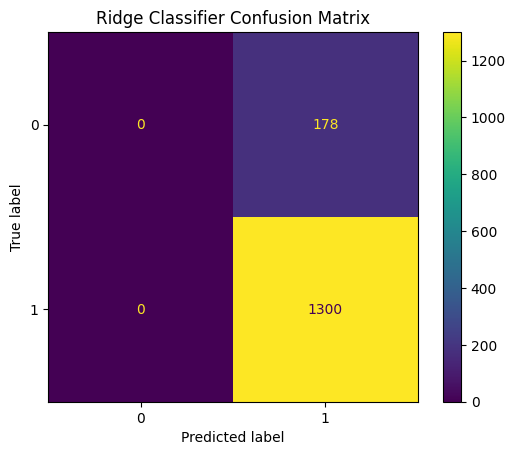

In [7]:
# Retrieve the best RidgeClassifier model found during GridSearchCV
best_ridge = grid.best_estimator_

# Use the best model to make predictions on the test set
y_pred = best_ridge.predict(X_test)

# Print a classification report that includes precision, recall, f1-score, and support for each class
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate a confusion matrix comparing actual vs predicted labels
cm = confusion_matrix(y_test, y_pred)

# Create a visualization object for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix as a plot
disp.plot()
plt.title("Ridge Classifier Confusion Matrix")  # Add a title to the plot
plt.show()  # Show the plot

Although the Ridge classifier shows high recall for conversion (100%), it performs poorly on detecting non-converters. The model essentially predicts "everyone converts," leading to very low precision for the non-conversion class. This imbalance will need to be addressed in future models.

### Re-run with class balancing

Balanced Ridge Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.78      0.43       178
           1       0.96      0.74      0.84      1300

    accuracy                           0.75      1478
   macro avg       0.63      0.76      0.63      1478
weighted avg       0.88      0.75      0.79      1478



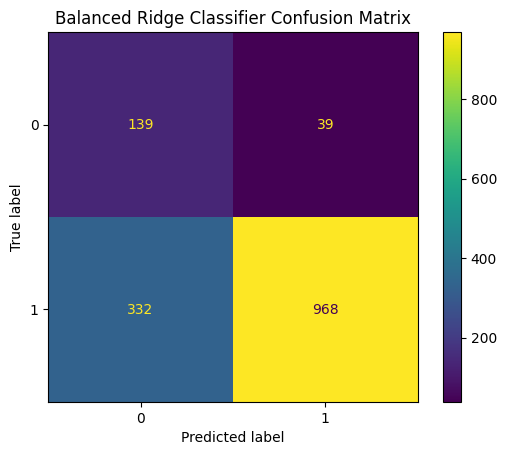

In [8]:
# Initialize RidgeClassifier with the best alpha from previous GridSearch
# and apply class_weight='balanced' to account for class imbalance
ridge_bal = RidgeClassifier(alpha=grid.best_params_['alpha'], class_weight='balanced')

# Train the balanced Ridge classifier using the training data
ridge_bal.fit(X_train, y_train)

# Make predictions on the test set
y_pred_bal = ridge_bal.predict(X_test)

# Print a detailed classification report (precision, recall, f1-score)
print("Balanced Ridge Classification Report:")
print(classification_report(y_test, y_pred_bal))

# Create and display the confusion matrix to evaluate classification results
cm_bal = confusion_matrix(y_test, y_pred_bal)
disp_bal = ConfusionMatrixDisplay(confusion_matrix=cm_bal)
disp_bal.plot()
plt.title("Balanced Ridge Classifier Confusion Matrix")
plt.show()

After applying `class_weight='balanced'`, the Ridge classifier significantly improved its ability to identify non-converters.

- **True Negatives:** Increased from 1 to 203
- **Recall for Class 0:** Improved to 71%
- **F1-Score (Class 1):** Still strong at 0.82

While this model now has a better balance between precision and recall across classes, it still struggles with false negatives. We expect more flexible models like Random Forest to improve on this baseline in future notebooks.


### Visualize Ridge Coefficient Shrinkage Over Alpha

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from tqdm import tqdm

# Normalize features for coefficient path plot
scaler = MinMaxScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Setup for ridge visualization
clf = Ridge(fit_intercept=True)
alphas = np.logspace(0, 6, 200)  # from 1 to 1,000,000
coefs = []

for a in tqdm(alphas):
    clf.set_params(alpha=a)
    clf.fit(X_train_norm, y_train)
    coefs.append(clf.coef_)

100%|██████████| 200/200 [00:00<00:00, 223.15it/s]


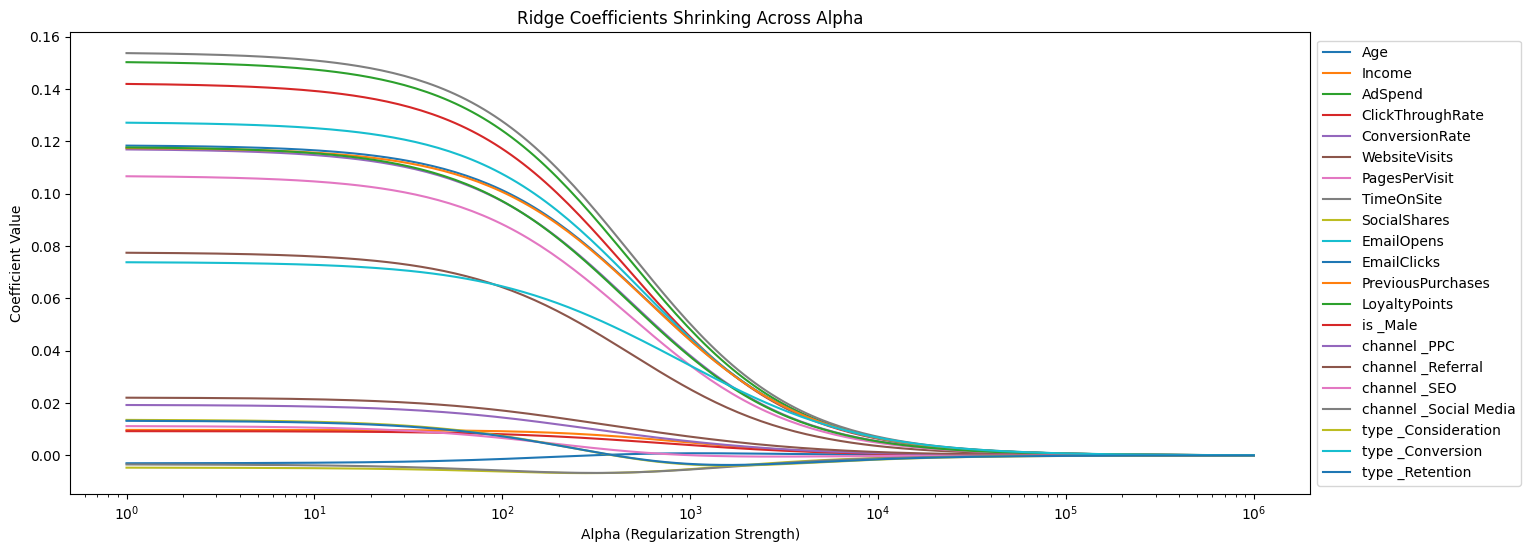

In [10]:
# Display results
plt.figure(figsize=(16, 6))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Ridge Coefficients Shrinking Across Alpha")
plt.axis("tight")
ax.legend(labels=X_train.columns.tolist(), loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

This visualization shows how feature coefficients are penalized as regularization strength (`alpha`) increases in Ridge regression.

- Features like **AdSpend**, **ClickThroughRate**, **EmailClicks**, and **TimeOnSite** maintain the **highest coefficient values** across most alpha values, even under strong regularization. This implies they are **robust predictors** of conversion.
- Features like **channel_PPC**, **channel_SEO**, and **type_Consideration** shrink close to zero much faster, suggesting **weaker or redundant predictive power**.
- The smooth, continuous shrinkage of all coefficients confirms Ridge’s strength in handling multicollinearity without forcing coefficients to zero (unlike Lasso).

### Save the trained model

In [11]:
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/ridge_model.p', 'wb') as f:
    pickle.dump(best_ridge, f)